In [28]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
import pandas as pd

In [23]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [24]:
df1 = read_csv('merge_oil.csv', header=0, index_col=0)
df1.index = pd.to_datetime(df1["Date"],format="%Y-%m-%d")

df1 = df1[["TCI_Close","TCI_Open","TCI_High","TCI_Low","TCI_Volume","Price"]]
#"Price","US_Price","Dollar_eq","Open","High","Low","Volume","Percent_Change"
df1 = df1.iloc[::-1]
print(df1.head())
values = df1.values

values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
print(reframed.head())
reframed.drop(reframed.columns[[7,8,9,10,11]], axis=1, inplace=True)
print(reframed.head())


            TCI_Close   TCI_Open   TCI_High    TCI_Low  TCI_Volume   Price
Date                                                                      
2011-12-12  59.900002  62.000000  62.450001  58.500000      2818.0  5203.0
2011-12-13  59.349998  59.900002  60.849998  58.000000      3453.0  5342.0
2011-12-14  60.000000  60.500000  60.500000  59.950001      1813.0  5209.0
2011-12-15  59.400002  60.500000  60.500000  58.700001      4391.0  5036.0
2011-12-16  57.400002  60.500000  61.000000  57.099998      4706.0  4903.0
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var1(t)  \
1   0.045655   0.052204   0.050598   0.044404   0.003256   0.593148  0.043981   
2   0.043981   0.045885   0.045932   0.042872   0.003989   0.617694  0.045960   
3   0.045960   0.047691   0.044911   0.048844   0.002095   0.594208  0.044133   
4   0.044133   0.047691   0.044911   0.045016   0.005073   0.563659  0.038046   
5   0.038046   0.047691   0.046369   0.040116   0.005437   0.540173  0

In [25]:
values = reframed.values
#print(values)
split = int(len(list(df1["Price"]))*0.8)
train = values[:split,:]
test = values[split:,:]
train_X,train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
#print(test_y)

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1326, 1, 6) (1326,) (331, 1, 6) (331,)


Train on 1326 samples, validate on 331 samples
Epoch 1/50
 - 1s - loss: 0.2918 - val_loss: 0.5301
Epoch 2/50
 - 0s - loss: 0.2056 - val_loss: 0.3766
Epoch 3/50
 - 0s - loss: 0.1485 - val_loss: 0.2211
Epoch 4/50
 - 0s - loss: 0.0855 - val_loss: 0.0500
Epoch 5/50
 - 0s - loss: 0.0601 - val_loss: 0.0297
Epoch 6/50
 - 0s - loss: 0.0398 - val_loss: 0.0181
Epoch 7/50
 - 0s - loss: 0.0233 - val_loss: 0.0301
Epoch 8/50
 - 0s - loss: 0.0189 - val_loss: 0.0232
Epoch 9/50
 - 0s - loss: 0.0250 - val_loss: 0.0213
Epoch 10/50
 - 0s - loss: 0.0202 - val_loss: 0.0294
Epoch 11/50
 - 0s - loss: 0.0171 - val_loss: 0.0176
Epoch 12/50
 - 0s - loss: 0.0243 - val_loss: 0.0219
Epoch 13/50
 - 0s - loss: 0.0185 - val_loss: 0.0252
Epoch 14/50
 - 0s - loss: 0.0156 - val_loss: 0.0180
Epoch 15/50
 - 0s - loss: 0.0236 - val_loss: 0.0253
Epoch 16/50
 - 0s - loss: 0.0181 - val_loss: 0.0269
Epoch 17/50
 - 0s - loss: 0.0160 - val_loss: 0.0174
Epoch 18/50
 - 0s - loss: 0.0249 - val_loss: 0.0275
Epoch 19/50
 - 0s - loss: 

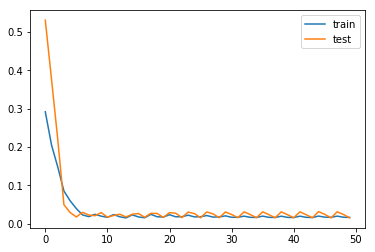

Test RMSE: 7.722


In [26]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


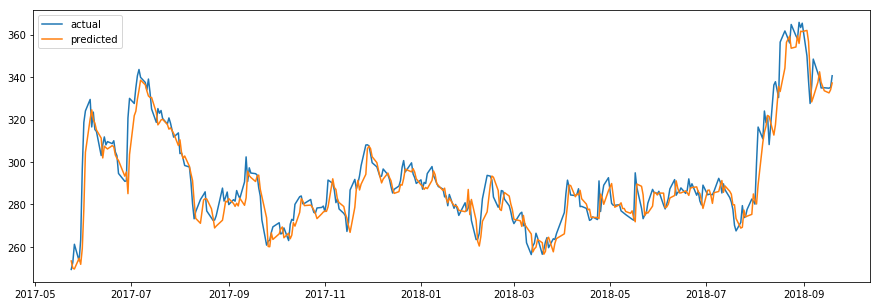

In [29]:
df = read_csv('merge_oil.csv', header=0, index_col=0)
df = df.iloc[::-1]
df.index = pd.to_datetime(df["Date"],format="%Y-%m-%d")

plot_df = pd.DataFrame({'Date':df.iloc[split+1:]["Date"],'Actual':inv_y,'Predicted':inv_yhat})
plot_df.index = pd.to_datetime(plot_df["Date"],format="%Y-%m-%d")

split = int(len(list(df["IOC_Low"]))*0.8)
dates = df.iloc[split+1:]["Date"]

fig = pyplot.figure(figsize=(15,5))

pyplot.plot(plot_df['Actual'],label='actual')
pyplot.plot(plot_df['Predicted'],label='predicted')
#pyplot.xticks(rotation=90)
pyplot.legend()
pyplot.show()

#print(dates)

In [30]:
print(list(inv_y))

[249.40001, 252.75, 261.24997, 253.39996, 263.39996, 296.6, 318.65, 324.05, 329.45004, 316.5, 323.49997, 315.3, 314.35, 303.04996, 308.04996, 311.79996, 308.04996, 309.6, 308.65, 310.0, 304.74997, 302.95, 294.6, 290.89996, 291.1, 320.75, 329.95, 327.54996, 334.85, 340.60004, 343.55, 339.85, 337.45, 333.95004, 339.05, 332.8, 324.94998, 318.65, 325.14996, 322.95, 324.25, 320.5, 317.9, 320.75, 318.3, 314.89996, 311.7, 313.7, 303.95, 304.24997, 301.6, 298.34998, 297.65, 290.49997, 280.35, 273.25, 276.6, 282.3, 284.65, 285.94998, 276.94998, 273.65, 272.55, 272.64996, 274.65, 287.7, 281.6, 283.45, 285.85, 279.95, 282.25, 281.55, 286.55, 284.45, 282.84998, 290.6, 302.4, 290.85, 297.25, 294.8, 294.49997, 293.85, 287.84998, 283.9, 272.75, 260.85, 262.75, 263.1, 266.8, 269.45, 271.4, 266.1, 266.49997, 268.95, 263.0, 270.7, 273.0, 272.39996, 280.05, 283.65, 284.0, 280.3, 280.49997, 282.35, 278.65, 276.24997, 275.95, 278.34998, 278.59998, 279.25, 276.64996, 281.1, 291.5, 289.95, 286.64996, 280.85,

In [31]:
print(list(inv_yhat))

[253.40413, 250.0363, 249.60966, 254.71518, 251.80978, 259.1556, 277.8854, 304.5527, 320.20926, 324.54984, 319.97897, 318.2948, 315.07825, 311.25317, 301.89993, 307.43484, 306.74588, 306.1372, 307.69464, 307.167, 303.26788, 301.7652, 300.68762, 293.31845, 295.31094, 285.0877, 303.51605, 321.8126, 323.88156, 329.62558, 333.82962, 338.52542, 336.35675, 333.4713, 331.07806, 330.42093, 330.37784, 323.23727, 317.48288, 318.49963, 319.8126, 320.06595, 317.71265, 315.46976, 316.1039, 314.7237, 313.45007, 307.7561, 310.43063, 304.44873, 301.67087, 302.82605, 297.95715, 294.45502, 291.2736, 281.59628, 273.4535, 271.12976, 282.11584, 282.74017, 282.5949, 277.98398, 273.91653, 268.93567, 269.8065, 272.57965, 276.8546, 281.575, 281.1499, 282.74283, 280.47537, 279.09784, 280.5919, 279.30826, 282.94345, 279.59946, 283.12372, 295.62888, 293.55316, 292.7185, 290.80484, 293.31512, 293.8389, 287.13547, 283.7453, 273.7015, 260.21002, 260.09805, 266.5755, 263.53, 266.15628, 268.51123, 269.38754, 264.32288

            TCI_Close   TCI_Open   TCI_High    TCI_Low  TCI_Volume
Date                                                              
2011-12-12  59.900002  62.000000  62.450001  58.500000      2818.0
2011-12-13  59.349998  59.900002  60.849998  58.000000      3453.0
2011-12-14  60.000000  60.500000  60.500000  59.950001      1813.0
2011-12-15  59.400002  60.500000  60.500000  58.700001      4391.0
2011-12-16  57.400002  60.500000  61.000000  57.099998      4706.0
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var1(t)   var2(t)  \
1   0.045655   0.052204   0.050598   0.044404   0.003256  0.043981  0.045885   
2   0.043981   0.045885   0.045932   0.042872   0.003989  0.045960  0.047691   
3   0.045960   0.047691   0.044911   0.048844   0.002095  0.044133  0.047691   
4   0.044133   0.047691   0.044911   0.045016   0.005073  0.038046  0.047691   
5   0.038046   0.047691   0.046369   0.040116   0.005437  0.025263  0.038363   

    var3(t)   var4(t)   var5(t)  
1  0.045932  0.0

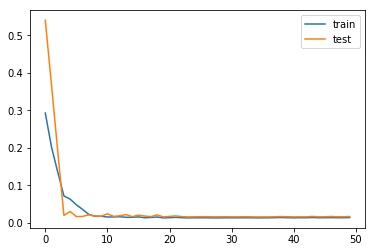

Test RMSE: 8.247


In [33]:
df1 = read_csv('merge_oil.csv', header=0, index_col=0)
df1.index = pd.to_datetime(df1["Date"],format="%Y-%m-%d")

df1 = df1[["TCI_Close","TCI_Open","TCI_High","TCI_Low","TCI_Volume"]]
#"Price","US_Price","Dollar_eq","Open","High","Low","Volume","Percent_Change"
df1 = df1.iloc[::-1]
print(df1.head())
values = df1.values

values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
print(reframed.head())
reframed.drop(reframed.columns[[6,7,8,9]], axis=1, inplace=True)
print(reframed.head())


values = reframed.values
#print(values)
split = int(len(list(df1["TCI_Close"]))*0.8)
train = values[:split,:]
test = values[split:,:]
train_X,train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
#print(test_y)

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


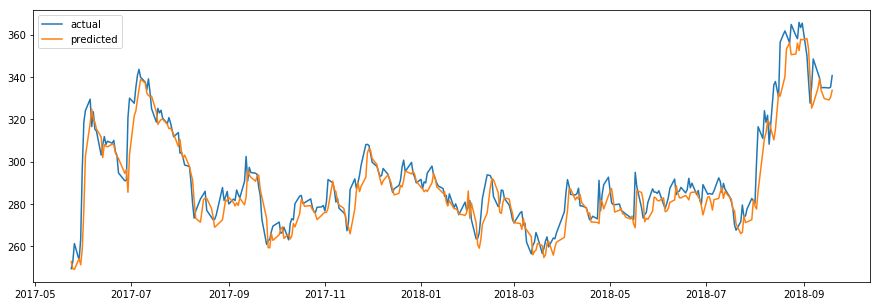

In [34]:
df = read_csv('merge_oil.csv', header=0, index_col=0)
df = df.iloc[::-1]
df.index = pd.to_datetime(df["Date"],format="%Y-%m-%d")

plot_df = pd.DataFrame({'Date':df.iloc[split+1:]["Date"],'Actual':inv_y,'Predicted':inv_yhat})
plot_df.index = pd.to_datetime(plot_df["Date"],format="%Y-%m-%d")

split = int(len(list(df["IOC_Low"]))*0.8)
dates = df.iloc[split+1:]["Date"]

fig = pyplot.figure(figsize=(15,5))

pyplot.plot(plot_df['Actual'],label='actual')
pyplot.plot(plot_df['Predicted'],label='predicted')
#pyplot.xticks(rotation=90)
pyplot.legend()
pyplot.show()

#print(dates)

In [35]:
print(list(inv_y))

[249.40001, 252.75, 261.24997, 253.39996, 263.39996, 296.6, 318.65, 324.05, 329.45004, 316.5, 323.49997, 315.3, 314.35, 303.04996, 308.04996, 311.79996, 308.04996, 309.6, 308.65, 310.0, 304.74997, 302.95, 294.6, 290.89996, 291.1, 320.75, 329.95, 327.54996, 334.85, 340.60004, 343.55, 339.85, 337.45, 333.95004, 339.05, 332.8, 324.94998, 318.65, 325.14996, 322.95, 324.25, 320.5, 317.9, 320.75, 318.3, 314.89996, 311.7, 313.7, 303.95, 304.24997, 301.6, 298.34998, 297.65, 290.49997, 280.35, 273.25, 276.6, 282.3, 284.65, 285.94998, 276.94998, 273.65, 272.55, 272.64996, 274.65, 287.7, 281.6, 283.45, 285.85, 279.95, 282.25, 281.55, 286.55, 284.45, 282.84998, 290.6, 302.4, 290.85, 297.25, 294.8, 294.49997, 293.85, 287.84998, 283.9, 272.75, 260.85, 262.75, 263.1, 266.8, 269.45, 271.4, 266.1, 266.49997, 268.95, 263.0, 270.7, 273.0, 272.39996, 280.05, 283.65, 284.0, 280.3, 280.49997, 282.35, 278.65, 276.24997, 275.95, 278.34998, 278.59998, 279.25, 276.64996, 281.1, 291.5, 289.95, 286.64996, 280.85,

In [36]:
print(list(inv_yhat))

[252.70747, 249.33154, 249.01425, 254.18768, 251.20549, 258.69485, 277.1175, 302.5995, 318.0678, 324.7601, 320.13132, 318.59064, 315.38596, 311.50702, 301.8882, 307.9662, 307.24936, 306.95444, 308.21774, 307.98264, 304.08228, 302.61975, 301.36197, 294.39218, 296.23175, 285.48105, 303.38025, 321.69513, 323.80402, 329.27237, 334.063, 338.8178, 337.08823, 332.3382, 331.16782, 330.6703, 330.87827, 323.48773, 317.56607, 318.8615, 319.79584, 319.9884, 317.5696, 315.53333, 315.81458, 314.34238, 312.96817, 307.08658, 310.4166, 304.57425, 301.61234, 303.02682, 297.76126, 294.35733, 291.326, 281.57285, 273.21918, 271.34134, 282.10458, 282.7056, 282.60547, 277.9083, 274.10626, 268.9634, 269.58896, 272.46667, 277.1747, 281.91516, 281.2541, 283.02374, 280.6239, 279.0213, 280.5229, 279.24802, 282.7269, 279.56015, 283.2308, 295.9204, 293.7307, 292.5684, 290.68994, 293.15512, 293.61392, 286.71124, 283.25952, 273.19553, 259.33838, 259.2028, 265.9512, 262.7382, 265.43506, 267.9066, 269.1157, 263.67603, 